In [1]:
import _init_paths

In [2]:
import datasets.dataset.jde as JDE
from datasets.dataset.jde import JointDataset
import torch
import torch.utils.data
from torchvision.transforms import transforms as T
from models.model import create_model, load_model, save_model
import importlib
importlib.reload(JDE)

<module 'datasets.dataset.jde' from '/workspace/Github_5AUA0_Project_G12T1/FairMOT/src/lib/datasets/dataset/jde.py'>

In [3]:
from opts import opts
import sys
sys.argv = ['/opt/conda/envs/dcnv2/lib/python3.8/site-packages/ipykernel_launcher.py', 'mot']
print(sys.argv)
sys.argv.append('--batch_size')
sys.argv.append('1')
# sys.argv.append('--batch_size')
# sys.argv.append('1')

['/opt/conda/envs/dcnv2/lib/python3.8/site-packages/ipykernel_launcher.py', 'mot']


In [4]:
opt = opts().parse(args='')

Fix size testing.
training chunk_sizes: [0, 1]
The output will be saved to  /workspace/Github_5AUA0_Project_G12T1/FairMOT/src/lib/../../exp/mot/default


## load dataset

In [5]:
trainset_paths = {"mot17": "./data/mot17.training"}
dataset_root = '/workspace/datasets/'
transforms = T.Compose([T.ToTensor()])
dataset = JointDataset(
    opt, dataset_root, trainset_paths, (1088, 608), augment=True, transforms=transforms
)
opt = opts().update_dataset_info_and_set_heads(opt, dataset)

dataset summary
OrderedDict([('mot17', 547.0)])
total # identities: 548
start index
OrderedDict([('mot17', 0)])
heads {'hm': 1, 'wh': 2, 'id': 512, 'reg': 2}


In [6]:
  train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=opt.batch_size,
        shuffle=True,
        num_workers=opt.num_workers,
        pin_memory=True,
        drop_last=True,
    )

## load model

In [7]:
model = create_model(opt.arch, opt.heads, opt.head_conv)

In [8]:
start_epoch = 0
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
if opt.load_model != "":
    model, optimizer, start_epoch = load_model(
        model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step
    )


## visualize model outputs and ground truth
model expects dict as input with following keys:

* input augmented image
* hm: heatmap that is generated from gaussian kernel using ground truth
* reg_mask: image prediction takes at max K objects which is zero filled, this mask either 1 or 0 depending if annotation was used at index 
* ind: integer index of image using  int(y)*w_output + int(x)
* wh: width height object
* reg:  width height offset, float(x,y) - int(x,y)
* ids: track id

In [12]:
print(opt.batch_size)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
plt.rcParams["figure.figsize"] = (10,10) #nice big plots
import numpy as np

1


In [13]:
def indtoxywh(ind):
    w_out, h_out = divmod(ind,272)
    return w_out, h_out

0
dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'ids'])
tensor(0)
torch.Size([1, 3, 608, 1088])
(608, 1088, 3)
tensor(18634)
w: 138, h: 68
tensor(17565)
w: 157, h: 64
tensor(17577)
w: 169, h: 64
tensor(27490)
w: 18, h: 101
tensor(17879)
w: 199, h: 65
tensor(17565)
w: 157, h: 64
tensor(17288)
w: 152, h: 63
tensor(18197)
w: 245, h: 66
tensor(18071)
w: 119, h: 66
tensor(17547)
w: 139, h: 64
tensor(17350)
w: 214, h: 63
tensor(17626)
w: 218, h: 64
tensor(17614)
w: 206, h: 64
tensor(16804)
w: 212, h: 61
tensor(16758)
w: 166, h: 61
tensor(16861)
w: 269, h: 61
tensor(17671)
w: 263, h: 64
tensor(17125)
w: 261, h: 62
tensor(17075)
w: 211, h: 62
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)
w: 0, h: 0
tensor(0)

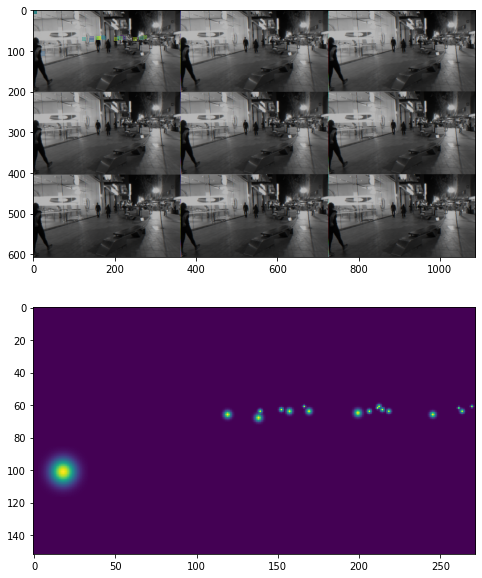

In [18]:
for iter_id, batch in enumerate(train_loader):
    print(iter_id)

# for k in batch:
# if k != 'meta':
#   batch[k] = batch[k].to(device=opt.device, non_blocking=True)


# output, loss, loss_stats = model_with_loss(batch)
# loss = loss.mean()
    print(batch.keys())
    print(batch['ind'][0,30])
    print(batch['input'].shape)
    img  = batch['input'][0,:,:,:].cpu().numpy().reshape(608,1088,3)
    print(img.shape)
    

    patcheslist = []
    #plot bounding boxes
    for i in range(128):
        print(batch['ind'][0,i])
        w, h = indtoxywh(batch['ind'][0,i].cpu().numpy())
        print(f"w: {h}, h: {w}")
        patcheslist.append(patches.Rectangle((h,w),10,10,linewidth=1,edgecolor='r',facecolor='none'))
    
    
    # Create figure and axes
    fig, (ax1,ax2) = plt.subplots(2)
    
    colors = 100*np.random.rand(len(patcheslist))
    p = PatchCollection(patcheslist, alpha=0.4)
    p.set_array(np.array(colors))
    ax1.add_collection(p)


    # Display the image
    ax1.imshow(img)

    # Create a Rectangle patch
    #rect = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    #ax1.add_patch(rect)
    print(batch['hm'].shape)
    ax2.imshow(batch['hm'][0,0,:,:])
    plt.show()
  
    break

 